In [2]:
import tensorflow as tf

x1 = tf.constant([1.3, 2.1, 3.2])
x2 = tf.constant([3.2, 3.2, 3.2])

result = tf.multiply(x1, x2)

print(result)

# run it in session
sess = tf.Session()
print(sess.run(result))
sess.close()

# in another way
with tf.Session() as sess :
    output = sess.run(result)
    print(output)

Tensor("Mul:0", shape=(3,), dtype=float32)
[ 4.16      6.72     10.240001]
[ 4.16      6.72     10.240001]


In [24]:
# start a new cell
import os
import skimage
from skimage import transform


def load_data(data_directory) :
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories :
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) for f in os.listdir(label_directory)
                      if f.endswith("ppm")]
        for f in file_names :
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


ROOT_PATH = "/Users/wujianmin/Code/git/rl-sutton/data"
train_path = os.path.join(ROOT_PATH, "Training")
test_path  = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_path)

In [15]:
import numpy as np

images = np.array(images)
labels = np.array(labels)

print(images.ndim)
print(images.size)

# print(images[0])

print(labels.ndim)
print(labels.size)

print(labels[0])

1
4575
1
4575
31


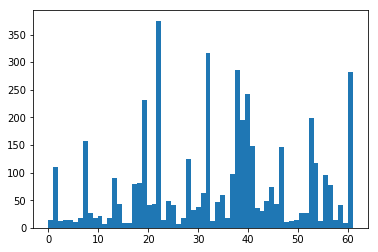

In [25]:
# what about the labels distribution
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

plt.hist(labels, 62)
plt.show()

shape: (236, 256, 3), min: 0, max: 255
shape: (133, 164, 3), min: 0, max: 255
shape: (122, 121, 3), min: 0, max: 255
shape: (123, 123, 3), min: 0, max: 215


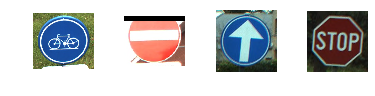

In [26]:
# spot check some examples

traffic_signs = [300, 2250, 3650, 4000]

for i in range(len(traffic_signs)) :
    plt.subplot(1, 4, i+1)
    plt.axis("off")
    plt.imshow(images[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)
    # plt.title("shape: {0}, min: {1}, max: {2}".format(images[traffic_signs[i]].shape, 
    #                                              images[traffic_signs[i]].min(),
    #                                              images[traffic_signs[i]].max()))
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(images[traffic_signs[i]].shape, 
                                                  images[traffic_signs[i]].min(),
                                                  images[traffic_signs[i]].max()))

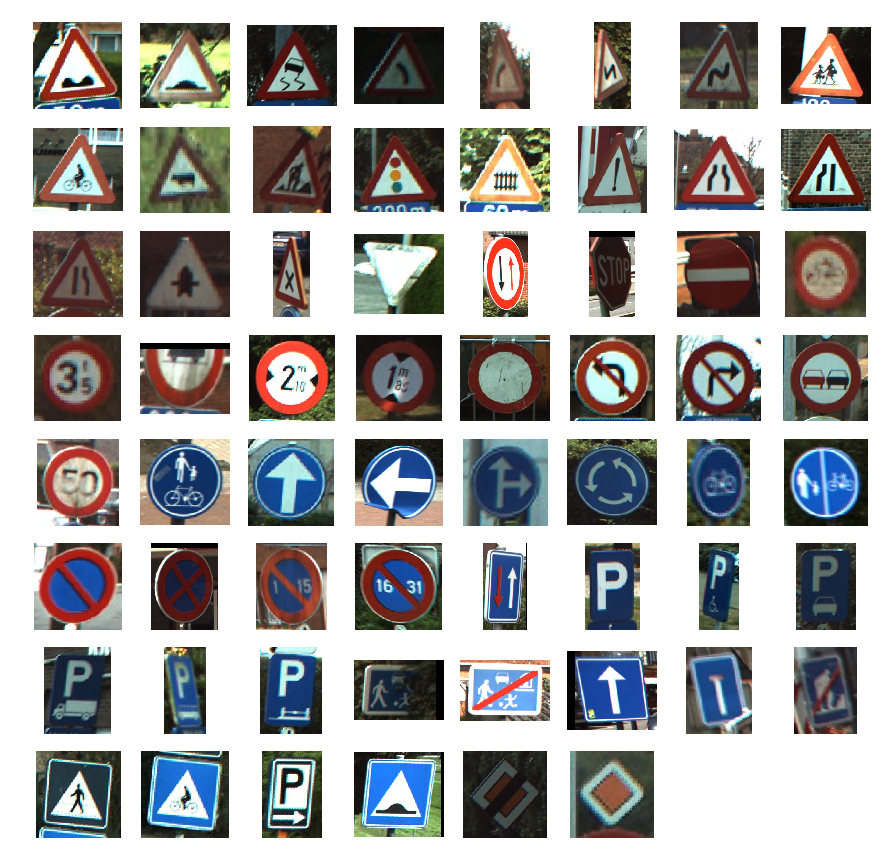

In [28]:
# a whole view browse

unique_labels = set(labels)

plt.figure(figsize = (15, 15))
i = 1

for label in unique_labels :
    image = images[labels.index(label)]
    plt.subplot(8, 8, i)
    plt.axis("off")
    ttl_obj = plt.title("Label {0} ({1})".format(label, labels.count(label)))
    plt.setp(ttl_obj, color='w')
    i += 1
    plt.imshow(image)
    

shape: (28, 28, 3), min: 0.08711484593837535, max: 0.9921568627450981
shape: (28, 28, 3), min: 0.0, max: 0.9921568627450981
shape: (28, 28, 3), min: 0.052893657462985216, max: 0.9652661064425767
shape: (28, 28, 3), min: 0.052254651860744294, max: 0.7078168767507003


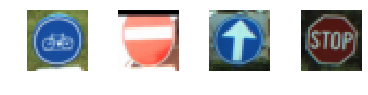

In [29]:
# scale them to the same size

from skimage import transform
images28 = [transform.resize(image, (28, 28)) for image in images]

traffic_signs = [300, 2250, 3650, 4000]
# spot-check again
for i in range(len(traffic_signs)) :
    plt.subplot(1, 4, i+1)
    plt.axis("off")
    plt.imshow(images28[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)
    # plt.title("shape: {0}, min: {1}, max: {2}".format(images[traffic_signs[i]].shape, 
    #                                              images[traffic_signs[i]].min(),
    #                                              images[traffic_signs[i]].max()))
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(images28[traffic_signs[i]].shape, 
                                                  images28[traffic_signs[i]].min(),
                                                  images28[traffic_signs[i]].max()))

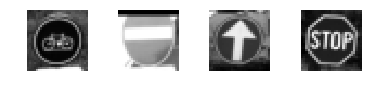

In [30]:
# make these images gray as the color contribute less to the classification task

from skimage.color import rgb2gray

images28 = np.array(images28)
images28 = rgb2gray(images28)

traffic_signs = [300, 2250, 3650, 4000]

for i in range(len(traffic_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images28[traffic_signs[i]], cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

In [32]:
# finally, we do the tensorflow stuff for model training
# 1. build the networks

import tensorflow as tf

x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28])
y = tf.placeholder(dtype = tf.int32, shape = [None])

# shape: [None, 784]
images_flat = tf.contrib.layers.flatten(x)

# shape: [None, 62]
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

# shape: [1]
loss   = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels = y, logits = logits))

train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

# shape: [None, 1]
correct_pred = tf.argmax(logits, 1)

# this looks not right
accuracy = tf.reduce_mean([int(y == y_) for y, y_ in zip(correct_pred, y)])

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", correct_pred)

images_flat:  Tensor("Flatten_1/flatten/Reshape:0", shape=(?, 784), dtype=float32)
logits:  Tensor("fully_connected_1/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean_2:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax_1:0", shape=(?,), dtype=int64)


In [36]:
# train the networks

tf.set_random_seed(1234)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(201) :
    _, loss_value = sess.run([train_op, loss], feed_dict = {x: images28, y: labels})
    if i % 10 == 0 :
        print("Loss: {0}".format(loss_value))

Loss: 4.237090110778809


Loss: 3.752443313598633


Loss: 3.5245554447174072


Loss: 3.3422739505767822


Loss: 3.190586805343628


Loss: 3.0650794506073


Loss: 2.962049961090088


Loss: 2.876579523086548


Loss: 2.8045859336853027


Loss: 2.743170738220215


Loss: 2.6901168823242188


Loss: 2.6437082290649414


Loss: 2.602560520172119


Loss: 2.5657732486724854


Loss: 2.5326032638549805


Loss: 2.5025107860565186


Loss: 2.4750187397003174
Loss: 2.4497339725494385


Loss: 2.426407814025879
Loss: 2.4048173427581787


Loss: 2.384742498397827


[39, 41, 35, 37, 28, 39, 38, 37, 25, 23]
[39 41 22 37 28 38 38 37 61 40]


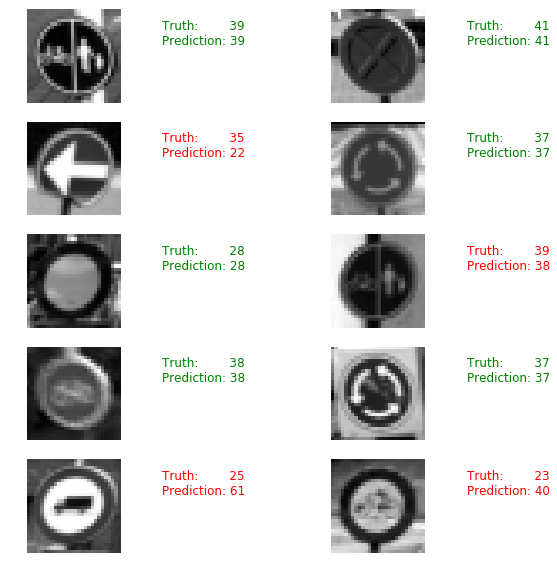

In [38]:
# let us evaluate how the model perform on randomly sampled examples from training set
import random

sample_indexes = random.sample(range(len(images28)), 10)
sample_images  = [images28[i] for i in sample_indexes]
sample_labels  = [labels[i] for i in sample_indexes]

predicted = sess.run([correct_pred], feed_dict={x : sample_images})[0]

print(sample_labels)
print(predicted)

fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2, 1+i)
    plt.axis('off')
    color = 'green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i],  cmap="gray")

plt.show()

In [40]:
# let us see how it works on test set

test_images, test_labels = load_data(test_path)
test_images28 = [transform.resize(image, [28, 28]) for image in test_images]
test_images28 = rgb2gray(np.array(test_images28))

predicted = sess.run([correct_pred], feed_dict = {x : test_images28})[0]
match_count = sum(int(y == y_) for y, y_ in zip(test_labels, predicted))
accuracy = match_count / len(test_labels)

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.367
